<a href="https://colab.research.google.com/github/YinYinTan/CIND820FinalProject/blob/main/4a_Random_Forest_Classification_Models_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Classification Models using Working Dataset with Principal Components

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
import time

In [2]:
#Read file
df = pd.read_csv('3b. Working Dataset - PCA.csv', index_col=None)

# 1. All Principal Components in Working Dataset - Evaluation using Train-Test Split

In [ ]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [ ]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Random forest classification model

t1 = time.perf_counter() #time counter start

model = RandomForestClassifier(random_state=888)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

t2 = time.perf_counter() #time counter ends

#Save results into dictionary
rf_all_base_pca = {'Accuracy':metrics.accuracy_score(y_test, y_pred), 'Precision':metrics.precision_score(y_test, y_pred),'Recall':metrics.recall_score(y_test, y_pred),\
          'F1-Score':metrics.f1_score(y_test, y_pred),'AUC':metrics.roc_auc_score(y_test, y_pred),'Brier Score':metrics.brier_score_loss(y_test, y_pred),'Execution Time (sec)':int(t2-t1)}

#Evaluation of random forest classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))
print('Execution time in seconds:', int(t2-t1))

Accuracy: 0.6581986143187067
Precision: 0.7531592249368155
Recall: 0.7493713327745181
F1-score: 0.7512605042016807
Area Under Curve (AUC): 0.602886037444773
Brier Score: 0.3418013856812933
Execution time in seconds: 12


# 2. All Principal Components in Working Dataset - Hyperparameter Tuning

### 2.1 Random Search with Cross Validation
In this section, a grid of hyperparameter ranges will be defined, and randomly sampled from the grid, where k-fold cross validation will be performed with each combination of values.

In [ ]:
from pprint import pprint

#Look at parameters currently used by the model
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 888,
 'verbose': 0,
 'warm_start': False}


The following set of hyperparameters will be adjusted to narrow down the best combination of parameters:
*   n_estimators = number of trees in the forest
*   max_features = max number of features considered for splitting a node
*   max_depth = max number of levels in each decision tree
*   min_samples_split = min number of data points placed in a node before the node is split
*   min_samples_leaf = min number of data points allowed in a leaf node
*   bootstrap = method for sampling data points (with or without replacement)

In [ ]:
#Creation of a parameter grid to sample from during fitting. On each iteration, the algorithm will choose a different, random combination of parameter values.

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = [2, 4, 6, 8, 10]

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50],
 'max_features': [2, 4, 6, 8, 10],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}


In [ ]:
#Using the random grid to search for best parameters

#Create the base model to tune
model = RandomForestClassifier(random_state=888)

#Random search of parameters across 50 different combinations, using 3 fold cross validation
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50, cv = 3, scoring = 'recall', verbose=2, random_state=42, n_jobs = -1)

#Fit the random search model
model_random.fit(X_train, y_train)

#View the best parameters from fitting the random search (based on model with the best recall)
model_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [ ]:
#Evaluation of best model from random search
best = model_random.best_estimator_
y_pred=best.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.6697459584295612
Precision: 0.7368421052631579
Recall: 0.8097233864207879
F1-score: 0.7715654952076677
Area Under Curve (AUC): 0.5848245874590025
Brier Score: 0.3302540415704388


Compared to the default random forest parameters used in the prior "All Principal Components in Working Dataset - Evaluation using Train-Test Split" section, the best model from the grid search resulted in a 6.0% increase in Recall (the metric chosen for scoring).
*   Accuracy, F1-score, and Brier Score improved.
*   Accuracy increased by 1.2%, the F1-score increased by 2.0%, and the Brier Score decreased by 1.2%.
*   Precision and AUC actually decreased by 1.6% and 1.8%, respectively.

The best model found in the random search has the same values for 1 of the 6 parameters as the default model (i.e. min_samples_leaf = 1).

### 2.2 Grid Search with Cross Validation
The random search above narrowed down the range for each hyperparameter. In this section, every combination of settings is defined.

In [ ]:
from sklearn.model_selection import GridSearchCV

#Create the parameter grid based on the results of previous random search. This will try out 1 * 3 * 3 * 2 * 3 * 3 = 162 combinations of settings.
param_grid = {
    'bootstrap': [False],
    'max_depth': [25, 30, 35],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [500, 750, 1000]
}

#Create the base model to tune
model = RandomForestClassifier(random_state=888)

#Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = 'recall', n_jobs = -1, verbose = 2)

#Fit the grid search model
grid_search.fit(X_train, y_train)

#View the best parameters from fitting the grid search (based on model with the best recall)
grid_search.best_params_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1000}

In [ ]:
#Evaluate performance of best model from grid search
best = grid_search.best_estimator_
y_pred=best.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.7592378752886836
Precision: 0.8268744734625105
Recall: 0.8227158424140821
F1-score: 0.8247899159663865
Area Under Curve (AUC): 0.7207271234333863
Brier Score: 0.2407621247113164


Compared to the default random forest parameters used in the prior "All Principal Components in Working Dataset - Evaluation using Train-Test Split" section, the best model from the grid search resulted in a 7.3% increase in Recall (the metric chosen for scoring).
*   All other metrics also saw improvements. Accuracy, Precision, F1-score, and AUC increased by 10.1%, 7.4%, 7.4%, and 11.8%, respectively, whereas the Brier Score decreased by 10.1%.

The best model found in the grid search has the same value for 1 of the 6 parameters as the default model (i.e. min_samples_leaf = 1).

# 3. All Principal Components in Working Dataset, Using Parameters from Grid Search - Evaluation using Repeated 10-fold Cross Validation

In [ ]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats)

#Random forest classification model
model = RandomForestClassifier(bootstrap='False', max_depth=30, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=1000)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE()
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
rf_all_tuned_pca = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of random forest classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.6681296860358742
Precision: 0.7511235594162222
Recall: 0.7750024612251554
F1-score: 0.7628322202971342
Area Under Curve (AUC): 0.6033020964134437
Brier Score: 0.3318703139641256
Execution time in seconds: 39.85768799453375


# 4. Top Principal Components

## 4.1 Top 1 to 20 Principal Components
It was decided to build random forest models using only the top 1 to 20 principal components to compare performance.

In [ ]:
#Build classification model using 1 to 20 of the top principal components and compare performance on Recall

recall_test = []

for n in range(1, 21):

  #Split dataframe, using 80% for training and 20% for testing
  #Only select top n variables for X
  X = df.iloc[:,:n]
  y = df['Worse_MH']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  #Random forest classification model, using the parameters identified during hyperparameter tuning
  model = RandomForestClassifier(bootstrap='False', max_depth=30, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, random_state=888)
  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  #Save results into list
  recall_test.append(metrics.recall_score(y_test, y_pred))

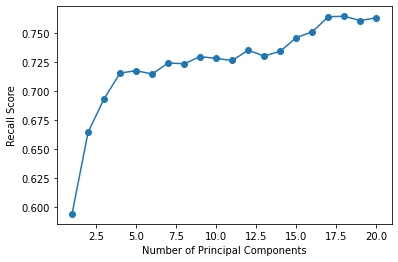

In [ ]:
#Plot recall scores against number of principal components used
plt.plot(range(1,21), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Principal Components')
plt.show()

In [4]:
#Build classification model using 1 to 20 of the top principal components and compare performance on Recall
from sklearn.model_selection import train_test_split

recall_test = []
components = len(df.columns)

for n in range(1, components):

  #Split dataframe, using 80% for training and 20% for testing
  #Only select top n variables for X
  X = df.iloc[:,:n]
  y = df['Worse_MH']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  #Random forest classification model, using the parameters identified during hyperparameter tuning
  model = RandomForestClassifier(bootstrap='False', max_depth=30, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, random_state=888)
  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  #Save results into list
  recall_test.append(metrics.recall_score(y_test, y_pred))

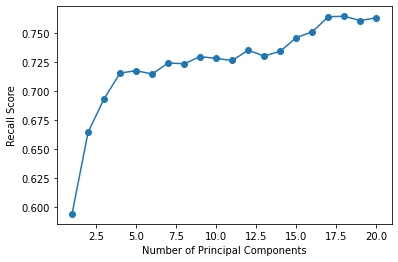

In [ ]:
#Plot recall scores against number of principal components used
plt.plot(range(1,components), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Principal Components')
plt.show()

Based on the plot above, it appears that model performance plateaus after the first 17 principal components.



## 4.2 Top 17 Principal Components - Evaluation using Repeated 10-fold Cross Validation
Based on the results above, it was decided to build a random forest model using the top 17 principal components.

In [ ]:
#Only select top 17 variables for X
X = df.iloc[:,:17]
y = df['Worse_MH']

In [ ]:
#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats)

#Random forest classification model, using the parameters identified during hyperparameter tuning
model = RandomForestClassifier(bootstrap='False', max_depth=30, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=1000)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE()
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
rf_17_tuned_pca = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of random forest classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.6535018716348043
Precision: 0.7500636494716361
Recall: 0.745271072306576
F1-score: 0.7476078225341165
Area Under Curve (AUC): 0.5978365256399916
Brier Score: 0.3464981283651959
Execution time in seconds: 38.63736094676654


# 5. Comparison of Models

In [ ]:
#Combine performance metrics for all models into one dataframe
comparison = pd.DataFrame([rf_all_base_pca, rf_all_tuned_pca, rf_17_tuned_pca], index=['RF All Components - Base (PCA)','RF All Components - Tuned (PCA)','RF 17 Components - Tuned (PCA)'])
comparison

,Accuracy,Precision,Recall,F1-Score,AUC,Brier Score,Execution Time (sec)
RF All Components - Base (PCA),0.658199,0.753159,0.749371,0.751261,0.602886,0.341801,12.000000
RF All Components - Tuned (PCA),0.668130,0.751124,0.775002,0.762832,0.603302,0.331870,39.857688
RF 17 Components - Tuned (PCA),0.653502,0.750064,0.745271,0.747608,0.597837,0.346498,38.637361


'RF All Features - Tuned', the random forest model using all features and the parameters identified during hyperparameter tuning, had the best Accuracy, Recall, F1-Score, and Brier Score, with a reasonable execution time of 10 seconds. It had the second best Precision and AUC, which was extremely close to the best scores achieves by the 'RF All Features - Base' model.

# 6. Stability of Best Model by Varying k-folds for Cross Validation

The stability of the best model identified above was tested by performing repeated k-folds cross-validation, with values of k from 3 to 15.

In [ ]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

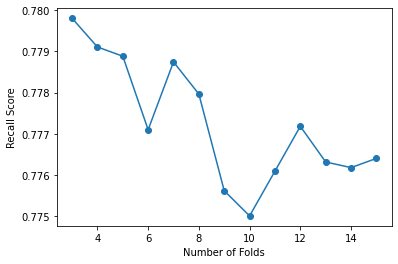

Range of Recall Scores: 0.4805939650863178


In [ ]:
recall_test = []

for k in range(3, 16):
  #Set cross-validation to k-folds, repeated 3 times
  repeats = 3
  rkf = RepeatedStratifiedKFold(n_splits=k, n_repeats=repeats)

  #Best random forest classification model identified in section 5, 'RF All Components - Tuned (PCA)'
  model = RandomForestClassifier(bootstrap='False', max_depth=30, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=1000)

  #Performance metrics
  recall = 0

  for train_index, test_index in rkf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)

    recall = recall + metrics.recall_score(y_test, y_pred)

  #Calculate average recall, append to list
  recall_test.append(recall/(k*repeats))

#Plot recall scores against number of folds used
plt.plot(range(3, 16), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Folds')
plt.show()

print("Range of Recall Scores (percent):", (max(recall_test)-min(recall_test))*100)

The model appears to be quite stable, with Recall ranging by less than 0.5%. It does appear that the performance decreases as the number of folks increase.